In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, ConcatDataset, random_split
from domainbed import algorithms, networks
import random
import numpy as np
import os

device = "cuda" if torch.cuda.is_available() else "cpu"

In [2]:
def fix_random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Fixed random seed: {seed}")

fix_random_seed(42)

# For deterministic DataLoader behavior
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

Fixed random seed: 42


In [3]:
# --- Constants ---
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]
BATCH_SIZE = 64
NUM_WORKERS = 0
TRAIN_RATIO = 0.95
VAL_RATIO = 0.05

# --- Transform ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(imagenet_mean, imagenet_std)
])

# --- Directories ---
art_dir = "data/pacs_data/pacs_data/art_painting"
cartoon_dir = "data/pacs_data/pacs_data/cartoon"
photo_dir = "data/pacs_data/pacs_data/photo"
sketch_dir = "data/pacs_data/pacs_data/sketch"

# --- Datasets ---
art_dataset = datasets.ImageFolder(root=art_dir, transform=transform)
cartoon_dataset = datasets.ImageFolder(root=cartoon_dir, transform=transform)
photo_dataset = datasets.ImageFolder(root=photo_dir, transform=transform)
sketch_dataset = datasets.ImageFolder(root=sketch_dir, transform=transform)  # target domain

# --- Seed setup for reproducibility ---
g = torch.Generator()
g.manual_seed(42)

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    torch.manual_seed(worker_seed)
    torch.cuda.manual_seed_all(worker_seed)

# --- Split each train domain into train/val ---
def split_dataset(dataset, ratio=TRAIN_RATIO, generator=g):
    total_size = len(dataset)
    train_size = int(ratio * total_size)
    val_size = total_size - train_size
    return random_split(dataset, [train_size, val_size], generator=generator)

art_train, art_val = split_dataset(art_dataset)
cartoon_train, cartoon_val = split_dataset(cartoon_dataset)
photo_train, photo_val = split_dataset(photo_dataset)

combined_train_dataset = ConcatDataset([art_train, cartoon_train, photo_train])
combined_val_dataset = ConcatDataset([art_val, cartoon_val, photo_val])

train_loader = DataLoader(
    combined_train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

val_loader = DataLoader(
    combined_val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

In [4]:
# --- Create a smaller subset of training data for gradient-based flatness analysis ---
from torch.utils.data import Subset

# Fraction of training data to use (e.g. 2%)
SMALL_TRAIN_FRACTION = .04

small_train_size = int(len(combined_train_dataset) * SMALL_TRAIN_FRACTION)
small_indices = torch.randperm(len(combined_train_dataset), generator=g)[:small_train_size]

small_train_subset = Subset(combined_train_dataset, small_indices)

small_train_loader = DataLoader(
    small_train_subset,
    batch_size=512,  # smaller batch helps keep GPU memory low
    shuffle=True,
    num_workers=0,
    pin_memory=True,
    worker_init_fn=seed_worker,
    generator=g
)

print(f"Subset created: {len(small_train_subset)} samples out of {len(combined_train_dataset)}")


Subset created: 230 samples out of 5757


In [5]:
# Same architecture for both
def get_model():
    model = models.resnet18(weights=None)
    model.fc = nn.Linear(model.fc.in_features, 7)
    return model.to(device)

erm_sgd_model = get_model()
erm_sgd_model.load_state_dict(torch.load("models/erm_sgd_512.pth", map_location=device))

sam_model = get_model()
sam_model.load_state_dict(torch.load("models/sam_512.pth", map_location=device))

erm_adam_model = get_model()
erm_adam_model.load_state_dict(torch.load("models/erm_adam.pth", map_location=device))


<All keys matched successfully>

In [6]:
hparams = {
    'lr': 0.001,
    'weight_decay': 0,
    'irm_lambda': 1,
    'irm_penalty_anneal_iters': 75,

    'nonlinear_classifier': 0,
    'resnet18': 1,
    'resnet_dropout': 0.0,
    'freeze_bn': 0,

    'mlp_width': 1024,
    'mlp_depth': 3,
    'mlp_dropout': 0.1,
    'vit': 0,
    'dinov2': 0,
    'vit_dropout': 0.0,
    'vit_attn_tune': 0,
}


# --- Initialize IRM ---
irm = algorithms.IRM(
    input_shape=(3, 224, 224),
    num_classes=7,
    num_domains=3,
    hparams=hparams
).to(device)

state_dict = torch.load("models/irm_lambda1.pth", map_location=device)
irm.load_state_dict(state_dict, strict=False)

c:\Program Files\Python313\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Program Files\Python313\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

In [7]:
import torch
from domainbed import algorithms

# --- Hyperparameters ---
hparams = {
    'lr': 0.001,
    'weight_decay': 0.0,
    'groupdro_eta': 1e-2,

    'nonlinear_classifier': 0,
    'resnet18': 1,
    'resnet_dropout': 0.0,
    'freeze_bn': 0,

    'mlp_width': 1024,
    'mlp_depth': 3,
    'mlp_dropout': 0.1,
    'vit': 0,
    'dinov2': 0,
    'vit_dropout': 0.0,
    'vit_attn_tune': 0,
}

device = "cuda" if torch.cuda.is_available() else "cpu"
num_domains = 3

# --- Initialize GroupDRO ---
groupDRO = algorithms.GroupDRO(
    input_shape=(3, 224, 224),
    num_classes=7,
    num_domains=num_domains,
    hparams=hparams
).to(device)

# --- Manually fix q before loading ---
# DomainBed initializes q lazily in __init__, sometimes as empty tensor
if not hasattr(groupDRO, "q") or groupDRO.q.numel() == 0:
    print(f"⚙️  Fixing GroupDRO.q → shape ({num_domains},)")
    groupDRO.q = torch.nn.Parameter(torch.ones(num_domains) / num_domains)

# --- Load state dict ---
state_dict = torch.load("models/groupDRO.pth", map_location=device)

# Fix checkpoint q if mismatch
if "q" in state_dict and state_dict["q"].shape[0] != num_domains:
    print(f"⚙️  Adjusting checkpoint q from {state_dict['q'].shape} → ({num_domains},)")
    state_dict["q"] = torch.ones(num_domains) / num_domains

groupDRO.load_state_dict(state_dict, strict=False)
print("✅ GroupDRO checkpoint loaded successfully.")


⚙️  Fixing GroupDRO.q → shape (3,)
✅ GroupDRO checkpoint loaded successfully.


In [8]:
def compute_loss(model, loader, criterion):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)
            total_loss += loss.item() * x.size(0)
    return total_loss / len(loader.dataset)


In [9]:
# def gradient_direction_perturbation(model, loader, criterion, epsilons, device, fwd):
#     model.to(device)
#     model.eval()
    
#     # 1️⃣ Compute gradient of training loss (use val loader or small batch)
#     inputs, labels = next(iter(loader))
#     inputs, labels = inputs.to(device), labels.to(device)

#     # zero grad
#     for p in model.parameters():
#         if p.grad is not None:
#             p.grad.zero_()
    
#     if not fwd:
#         outputs = model(inputs)
#     else:
#         outputs = model.predict(inputs)
#     loss = criterion(outputs, labels)
#     loss.backward()

#     # collect gradients and their L2 norm
#     grads = [p.grad.clone() for p in model.parameters() if p.grad is not None]
#     grad_norm = torch.sqrt(sum((g**2).sum() for g in grads))

#     # normalize direction
#     grads = [g / (grad_norm + 1e-12) for g in grads]

#     # store original params
#     original_params = [p.clone() for p in model.parameters()]
#     losses = []

#     # 2️⃣ Perturb along gradient direction
#     for eps in epsilons:
#         with torch.no_grad():
#             for p, g in zip(model.parameters(), grads):
#                 p.add_(eps * g)

#         # evaluate loss on val set
#         total_loss, total_samples = 0.0, 0
#         with torch.no_grad():
#             for x, y in loader:
#                 x, y = x.to(device), y.to(device)
#                 if not fwd:
#                     preds = model(x)
#                 else:
#                     preds = model.predict(x)
#                 l = criterion(preds, y)
#                 total_loss += l.item() * x.size(0)
#                 total_samples += x.size(0)
#         losses.append(total_loss / total_samples)

#         # restore params
#         with torch.no_grad():
#             for p, orig in zip(model.parameters(), original_params):
#                 p.copy_(orig)

#     return losses

In [10]:
def gradient_direction_perturbation(model, loader, criterion, epsilons, device):
    model.eval()
    model.to(device)
    losses = []

    # --- One small batch for computing gradient direction ---
    inputs, labels = next(iter(loader))
    inputs, labels = inputs.to(device), labels.to(device)

    # --- Forward pass ---
    try:
        outputs = model.predict(inputs)  # for DomainBed algorithms
    except AttributeError:
        outputs = model(inputs)

    loss = criterion(outputs, labels)

    # --- Compute gradients ---
    grads = torch.autograd.grad(
        loss,
        [p for p in model.parameters() if p.requires_grad],
        allow_unused=True,
        create_graph=False
    )

    # --- Replace None with zeros ---
    params = [p for p in model.parameters() if p.requires_grad]
    grads = [torch.zeros_like(p) if g is None else g for p, g in zip(params, grads)]

    # --- Normalize direction ---
    grad_norm = torch.sqrt(sum((g ** 2).sum() for g in grads))
    grads = [g / (grad_norm + 1e-12) for g in grads]

    # --- Evaluate perturbed losses ---
    for eps in epsilons:
        # Save original params
        original_params = [p.detach().clone() for p in params]

        # Apply perturbation
        with torch.no_grad():
            for p, g in zip(params, grads):
                p.add_(eps * g)

        # Evaluate perturbed loss
        total_loss, total_samples = 0.0, 0
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                try:
                    preds = model.predict(x)
                except AttributeError:
                    preds = model(x)
                l = criterion(preds, y)
                total_loss += l.item() * x.size(0)
                total_samples += x.size(0)
        losses.append(total_loss / total_samples)

        # Restore params
        with torch.no_grad():
            for p, orig in zip(params, original_params):
                p.copy_(orig)

    return losses


In [11]:
criterion = nn.CrossEntropyLoss()
epsilons = torch.linspace(-0.1, 0.1, 40).tolist()  # adjust range if needed

erm_adam_losses = gradient_direction_perturbation(erm_adam_model, small_train_loader, criterion, epsilons, device)
erm_sgd_losses = gradient_direction_perturbation(erm_sgd_model, small_train_loader, criterion, epsilons, device)
irm_losses = gradient_direction_perturbation(irm, small_train_loader, criterion, epsilons, device)
groupDRO_losses = gradient_direction_perturbation(groupDRO, small_train_loader, criterion, epsilons, device)
sam_losses = gradient_direction_perturbation(sam_model, small_train_loader, criterion, epsilons, device)

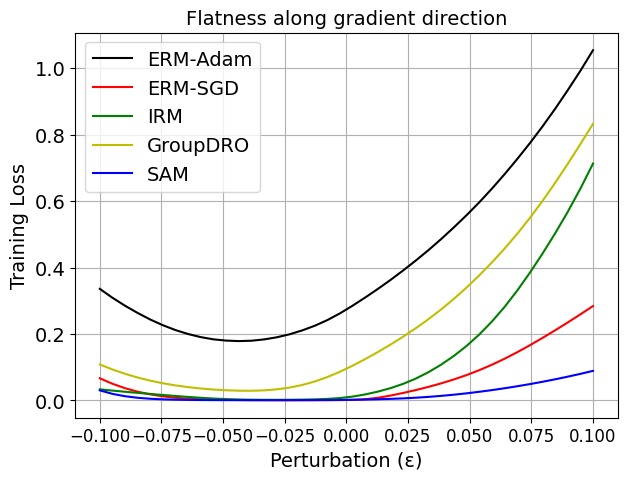

In [14]:
plt.figure(figsize=(7,5))
plt.plot(epsilons, erm_adam_losses, 'black', label='ERM-Adam')
plt.plot(epsilons, erm_sgd_losses, 'r', label='ERM-SGD')
plt.plot(epsilons, irm_losses, 'g', label='IRM')
plt.plot(epsilons, groupDRO_losses, 'y', label='GroupDRO')
plt.plot(epsilons, sam_losses, 'b', label='SAM')
plt.xlabel("Perturbation (ε)", fontsize= 14)
plt.ylabel("Training Loss", fontsize= 14)
plt.title("Flatness along gradient direction", fontsize= 14)
plt.xticks(fontsize= 12)
plt.yticks(fontsize= 14)
plt.legend(fontsize= 14)
plt.grid(True)
plt.show()

In [15]:
print(sam_losses)

[0.030375121161341667, 0.019757932052016258, 0.012609915807843208, 0.007951609790325165, 0.005033068358898163, 0.0032772719860076904, 0.0022372594103217125, 0.0016267196042463183, 0.0012633833102881908, 0.0010414381977170706, 0.0009040661389008164, 0.00082188326632604, 0.0007786882924847305, 0.0007672103238292038, 0.0007855779258534312, 0.0008356964681297541, 0.0009257274214178324, 0.0010695935925468802, 0.0012848813785240054, 0.0015989727107807994, 0.0020531429909169674, 0.002687151078134775, 0.0035576997324824333, 0.004726162645965815, 0.006263668183237314, 0.00824824534356594, 0.01073046587407589, 0.013739789836108685, 0.01728816330432892, 0.021380893886089325, 0.025998562574386597, 0.031066620722413063, 0.036625102162361145, 0.04264407232403755, 0.049109455198049545, 0.0560954324901104, 0.06354794651269913, 0.07150513678789139, 0.07997953146696091, 0.08898575603961945]


In [16]:
print(erm_sgd_losses)

[0.06668607890605927, 0.05016809701919556, 0.03672225400805473, 0.026200467720627785, 0.018157660961151123, 0.01221542339771986, 0.007977543398737907, 0.005155147053301334, 0.003399315057322383, 0.0023176586255431175, 0.0016456613084301353, 0.001225887332111597, 0.0009641238139010966, 0.0008025707793422043, 0.000705287849996239, 0.0006577693275175989, 0.0006536641158163548, 0.0006972537375986576, 0.0008081055129878223, 0.001062926254235208, 0.0017348055262118578, 0.003657390596345067, 0.007962712086737156, 0.014718824997544289, 0.022651145234704018, 0.03133146092295647, 0.040924590080976486, 0.05148889124393463, 0.06321274489164352, 0.07633043080568314, 0.09103039652109146, 0.10734493285417557, 0.12529973685741425, 0.14498576521873474, 0.16590464115142822, 0.18801893293857574, 0.21088820695877075, 0.23457495868206024, 0.2590371370315552, 0.2840893268585205]


In [17]:
index_zero = min(range(len(epsilons)), key=lambda i: abs(epsilons[i] - 0))

print("Index of epsilon closest to 0:", index_zero)

Index of epsilon closest to 0: 19


In [18]:
print(sam_losses[19])
print(erm_sgd_losses[19])

0.0015989727107807994
0.001062926254235208
